# **HOMEWORK 6: Decision Trees and Ensemble Learning**

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download using wget link mentioned below:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.shape

(20640, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [6]:
df.total_bedrooms.isnull().sum()

0

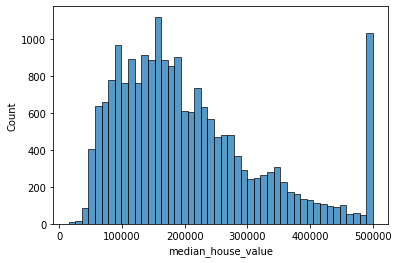

In [7]:
sns.histplot(df.median_house_value)

In [8]:
df.median_house_value.min()

14999.0

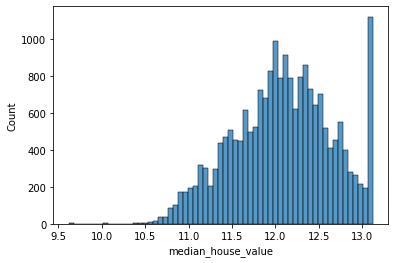

In [9]:
df['median_house_value'] = np.log(df['median_house_value'])
sns.histplot(df['median_house_value'])

- **Apply the log transform to median_house_value.**
- **Do train/validation/test split with 60%/20%/20% distribution.**
- **Use the train_test_split function and set the random_state parameter to 1.**


In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
9107,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,12.337539,INLAND
13999,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,10.915088,INLAND
5610,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,12.069680,NEAR OCEAN
13533,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,11.694413,INLAND
2953,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,11.055641,INLAND


In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,12.337539,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,10.915088,INLAND
2,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,12.069680,NEAR OCEAN
3,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,11.694413,INLAND
4,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,11.055641,INLAND


In [14]:
df_train['median_house_value']

0        12.337539
1        10.915088
2        12.069680
3        11.694413
4        11.055641
           ...    
12379    11.831379
12380    12.288574
12381    12.273731
12382    10.986986
12383    12.181268
Name: median_house_value, Length: 12384, dtype: float64

In [15]:
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

In [16]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [17]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND
2,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,NEAR OCEAN
3,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,INLAND
4,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,INLAND


**We will use DictVectorizer to turn train and validation into matrices.**

In [19]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

numerical = list(df_train.select_dtypes(include=np.number))

print(f'Categorical variables: {categorical}')
print(" ")
print(f'Numerical variables: {numerical}')

Categorical variables: ['ocean_proximity']
 
Numerical variables: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [20]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [21]:
X_train

array([[ 578.  ,   19.  ,   34.63, ..., 1677.  ,  606.  , 3562.  ],
       [  50.  ,   10.  ,   34.69, ...,  108.  ,  102.  ,  337.  ],
       [ 462.  ,   27.  ,   33.78, ..., 1723.  ,  491.  , 1672.  ],
       ...,
       [ 854.  ,   18.  ,   33.9 , ..., 2276.  ,  922.  , 3380.  ],
       [ 415.  ,   41.  ,   36.78, ..., 1129.  ,  462.  , 2227.  ],
       [ 589.  ,    9.  ,   34.02, ..., 2280.  ,  587.  , 4265.  ]])

# Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [22]:
#@ TRAINING THE REGRESSION MODEL:
model_dtr = DecisionTreeRegressor(max_depth=1, random_state=1)
model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [23]:
#@ INSPECTION:

print(export_text(model_dtr, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: **ocean_proximity**

# Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional-to make training faster)

In [24]:
#@ TRAINING RANDOM FOREST MODEL:

model_rfr = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
model_rfr.fit(X_train, y_train)
y_pred = model_rfr.predict(X_val)

In [25]:
#@ CALCULATING MEAN SQUARED ERROR:
mse = mean_squared_error(y_val, y_pred)
rmse = np.round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
rmse

0.245

- What's the RMSE of this model on validation?

- Answer: **0.245**

# Question 3

Now, let's experiment with the n_estimators parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

In [26]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores_q3 = []

for n in range(10,201,10):
  model_rf = RandomForestRegressor(n_estimators=n, random_state=1)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_val)

  scores_q3.append([n, round(np.sqrt(mean_squared_error(y_val, y_pred)),4)])

In [27]:
#@ INSPECTING THE RMSE SCORES:
df_scores_q3 = pd.DataFrame(scores_q3, columns=['n_estimators', 'RMSE'])
df_scores_q3

,n_estimators,RMSE
0,10,0.2454
1,20,0.2390
2,30,0.2353
3,40,0.2345
4,50,0.2330
5,60,0.2327
6,70,0.2322
7,80,0.2322
8,90,0.2319
9,100,0.2318


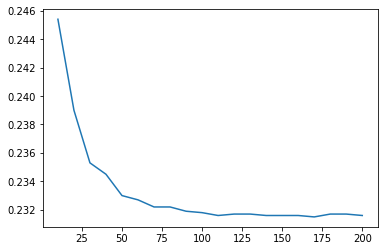

In [28]:
plt.plot(df_scores_q3.n_estimators, df_scores_q3.RMSE)

- After which value of n_estimators does RMSE stop improving?

- Answer: Around after the value of **110**th n_estimator, RMSE stops improving.

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: random_state=1.

In [29]:
#@ TRAINING THE MODEL WITH DEPTH:
scores_q4 = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        model_rfr = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        model_rfr.fit(X_train, y_train)
        y_pred = model_rfr.predict(X_val)

        scores_q4.append([d, n, round(mean_squared_error(y_val, y_pred),4)])

In [30]:
df_scores_q4 = pd.DataFrame(scores_q4, columns=['max_depth','n_estimators', 'MSE'])
pd.set_option('display.max_rows', None)
df_scores_q4.sort_values(by='MSE', ascending=True)

,max_depth,n_estimators,MSE
79,25,200,0.0537
78,25,190,0.0537
76,25,170,0.0537
75,25,160,0.0537
74,25,150,0.0537
73,25,140,0.0537
50,20,110,0.0537
71,25,120,0.0537
70,25,110,0.0537
51,20,120,0.0537


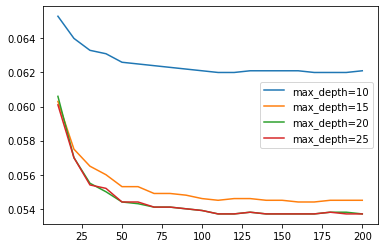

In [31]:
for d in [10, 15, 20, 25]:
    df_subset_q4 = df_scores_q4[df_scores_q4.max_depth == d]
    
    plt.plot(df_subset_q4.n_estimators, df_subset_q4.MSE,
             label='max_depth=%d' % d)

plt.legend()

- What's the best max_depth:

- Answer: Both value of **20** and **25** of max_depth look the same.

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the **feature_importances_** field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:

- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

In [32]:
#@ TRAINING THE RANDOM FOREST MODEL:
model_rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
model_rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

- What's the most important feature?

- Answer: **total_bedrooms**

In [33]:
df_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [34]:
model_rfr.feature_importances_

array([1.68883796e-02, 3.29234610e-02, 1.00635995e-01, 9.68721148e-02,
       3.63889964e-01, 3.06679246e-03, 3.10901161e-01, 3.58566277e-04,
       2.70076860e-04, 4.21955925e-03, 3.00099243e-02, 1.90503449e-02,
       2.09136608e-02])

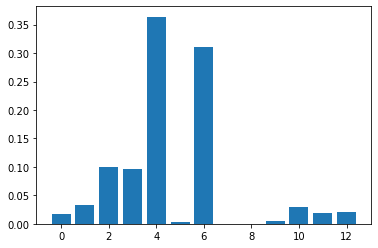

In [35]:
plt.bar(range(len(model_rfr.feature_importances_)), model_rfr.feature_importances_)
plt.show()

4th feature is the most important one which is 'total_bedrooms'.

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

  xgb_params = {  
      'eta': 0.3,  
      'max_depth': 6,  
      'min_child_weight': 1,  

      'objective': 'reg:squarederror',
      'nthread': 8,

      'seed': 1,
      'verbosity': 1,
  }

In [36]:
 #@ CREATING THE DMATRIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [37]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter','train_rmse','val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [38]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [64]:
scores = {}

In [71]:
%%capture output

xgb_params = {  
    'eta': 0.01,
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'eval_metric': 'rmse',

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,evals=watchlist)

In [72]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [73]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1', 'eta=0.01'])

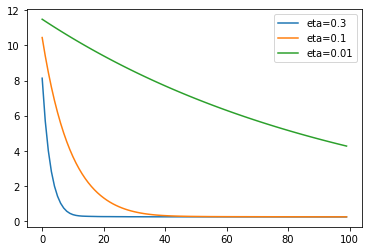

In [74]:
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_rmse, label=key)
plt.legend()

- Now, change eta first to 0.1 and then to 0.01.
- Which eta leads to the best RMSE score on the validation dataset?

- Answer: **0.3**